# Render thank you message

In [16]:
import requests
import pandas as pd
response = requests.get("https://gciro.pythonanywhere.com/metadata")

df = pd.DataFrame(response.json())

a = df.annotator_name.unique().tolist()
names = []
for i in a:

    if "test" in i.lower():
        continue

    splitted = i.split(" ")
    first_name = splitted[0].strip().capitalize()
    last_name = ""
    if len(splitted) > 1:
        last_name = splitted[1].strip().capitalize()[0]+"."
    name = first_name + " " + last_name
    name = name.strip()
    names.append(name)
print(", ".join(sorted(names)))

Carmen, Claudia, Claudia, Diana, Francesca, Giovanni, Giovanni P., Lorenzo, Matilde, Sara, Simone P., Tommaso D.


# Render Model-agreement table

In [23]:
import csv

PATH_TO_CSV = "evaluation/model-expert-agreement.csv"

mapped_names = {
    "vgg": "VGG-16",
    "in": "InceptionNet-V1",
    "an": "AlexNet",
    "rn": "ResNet-50",
}

def bold_if_significant(value, pval):
    """Bold the value if p-value < 0.05"""
    value = f"{float(value)*100:.2f}"
    try:
        pval = f"{float(pval):.3f}"
        if float(pval) > 0.05:
            return f"\\textit{{{value} {{\\scriptsize {pval}}}}}"
        else:
            return f"{value} {{\\scriptsize {pval}}}"
    except (ValueError, TypeError):
        return f"{value} {{\\scriptsize {pval}}}"

def create_latex_table(csv_file):
    # Read the CSV file
    with open(csv_file, 'r') as file:
        reader = csv.DictReader(file)
        data = [row for row in reader if row.get('linear').lower() == 'true' and row.get('pretrained').lower() == 'true']
    
    if not data:
        print("No models with linear=true and pretrained=true found in the CSV.")
        return
    
    # Start creating the LaTeX table
    latex_table = []
    latex_table.append("\\begin{table*}[t]")
    latex_table.append("    \\centering")
    latex_table.append("    \\setlength{\\tabcolsep}{3pt}")
    latex_table.append("    \\caption{\\textbf{Performance-Agreement Correlation.} Entries show correlations between model performances and saliency map scores. P-values are reported and significant results are highlighted in bold.}")
    
    # Create the tabular environment with multicolumns
    latex_table.append("    \\begin{tabularx}{\\linewidth}{l|YY|YY|YY}")
    latex_table.append("        \\toprule")
    latex_table.append("        \\multirow{2}{*}{Model} & \\multicolumn{2}{c|}{GradCAM} & \\multicolumn{2}{c|}{CAM} & \\multicolumn{2}{c}{Random} \\\\")
    latex_table.append("        & IoU & PG & IoU & PG & IoU & PG \\\\")
    latex_table.append("        \\midrule")
    
    # Add each model as a row
    for row in data:
        model_name = row.get('model', 'Unknown')
        model_name = mapped_names[model_name]
        # Format each cell with value and p-value in scriptsize
        gradcam_iou = bold_if_significant(row.get('GradCAM_iou', '-'), row.get('GradCAM_iou_pval', '-'))
        gradcam_pg = bold_if_significant(row.get('GradCAM_pg', '-'), row.get('GradCAM_pg_pval', '-'))
        
        cam_iou = bold_if_significant(row.get('CAM_iou', '-'), row.get('CAM_iou_pval', '-'))
        cam_pg = bold_if_significant(row.get('CAM_pg', '-'), row.get('CAM_pg_pval', '-'))
        
        random_iou = bold_if_significant(row.get('Random_iou', '-'), row.get('Random_iou_pval', '-'))
        random_pg = bold_if_significant(row.get('Random_pg', '-'), row.get('Random_pg_pval', '-'))
        
        # Add the row
        latex_table.append(f"        {model_name} & {gradcam_iou} & {gradcam_pg} & {cam_iou} & {cam_pg} & {random_iou} & {random_pg} \\\\")
    
    # Finish the table
    latex_table.append("        \\bottomrule")
    latex_table.append("    \\end{tabularx}")
    latex_table.append("    \\label{tb:ModelSaliencyComparison}")
    latex_table.append("\\end{table*}")
    
    # Join all lines and return
    return "\n".join(latex_table)

latex = create_latex_table(PATH_TO_CSV)
with open(PATH_TO_CSV.replace(".csv", ".txt"), "w") as f:
    f.write(latex)
print(latex)

\begin{table*}[t]
    \centering
    \setlength{\tabcolsep}{3pt}
    \caption{\textbf{Performance-Agreement Correlation.} Entries show correlations between model performances and saliency map scores. P-values are reported and significant results are highlighted in bold.}
    \begin{tabularx}{\linewidth}{l|YY|YY|YY}
        \toprule
        \multirow{2}{*}{Model} & \multicolumn{2}{c|}{GradCAM} & \multicolumn{2}{c|}{CAM} & \multicolumn{2}{c}{Random} \\
        & IoU & PG & IoU & PG & IoU & PG \\
        \midrule
        AlexNet & 8.43 {\scriptsize 0.000} & 16.67 {\scriptsize 0.049} & \textit{2.12 {\scriptsize 0.543}} & \textit{8.33 {\scriptsize 0.311}} & 1.56 {\scriptsize -} & 2.78 {\scriptsize -} \\
        InceptionNet-V1 & 12.77 {\scriptsize 0.000} & 27.78 {\scriptsize 0.003} & 12.77 {\scriptsize 0.000} & 27.78 {\scriptsize 0.003} & 2.83 {\scriptsize -} & 2.78 {\scriptsize -} \\
        ResNet-50 & 6.21 {\scriptsize 0.008} & 36.11 {\scriptsize 0.000} & 5.84 {\scriptsize 0.010} & 36.11

# Inspect Trained Model (predictions + gradcam)

### Explore RN and VGG

Generating consensus masks to identify valid images for plotting...
Found 24 images with non-empty consensus for potential plotting.
Selected 5 images for plotting.
Generating CAMs and calculating IoUs...
Plot saved to: plots/Saliency_vs_Expert_person47_virus_99_person96_bacteria_465_person63_v.png


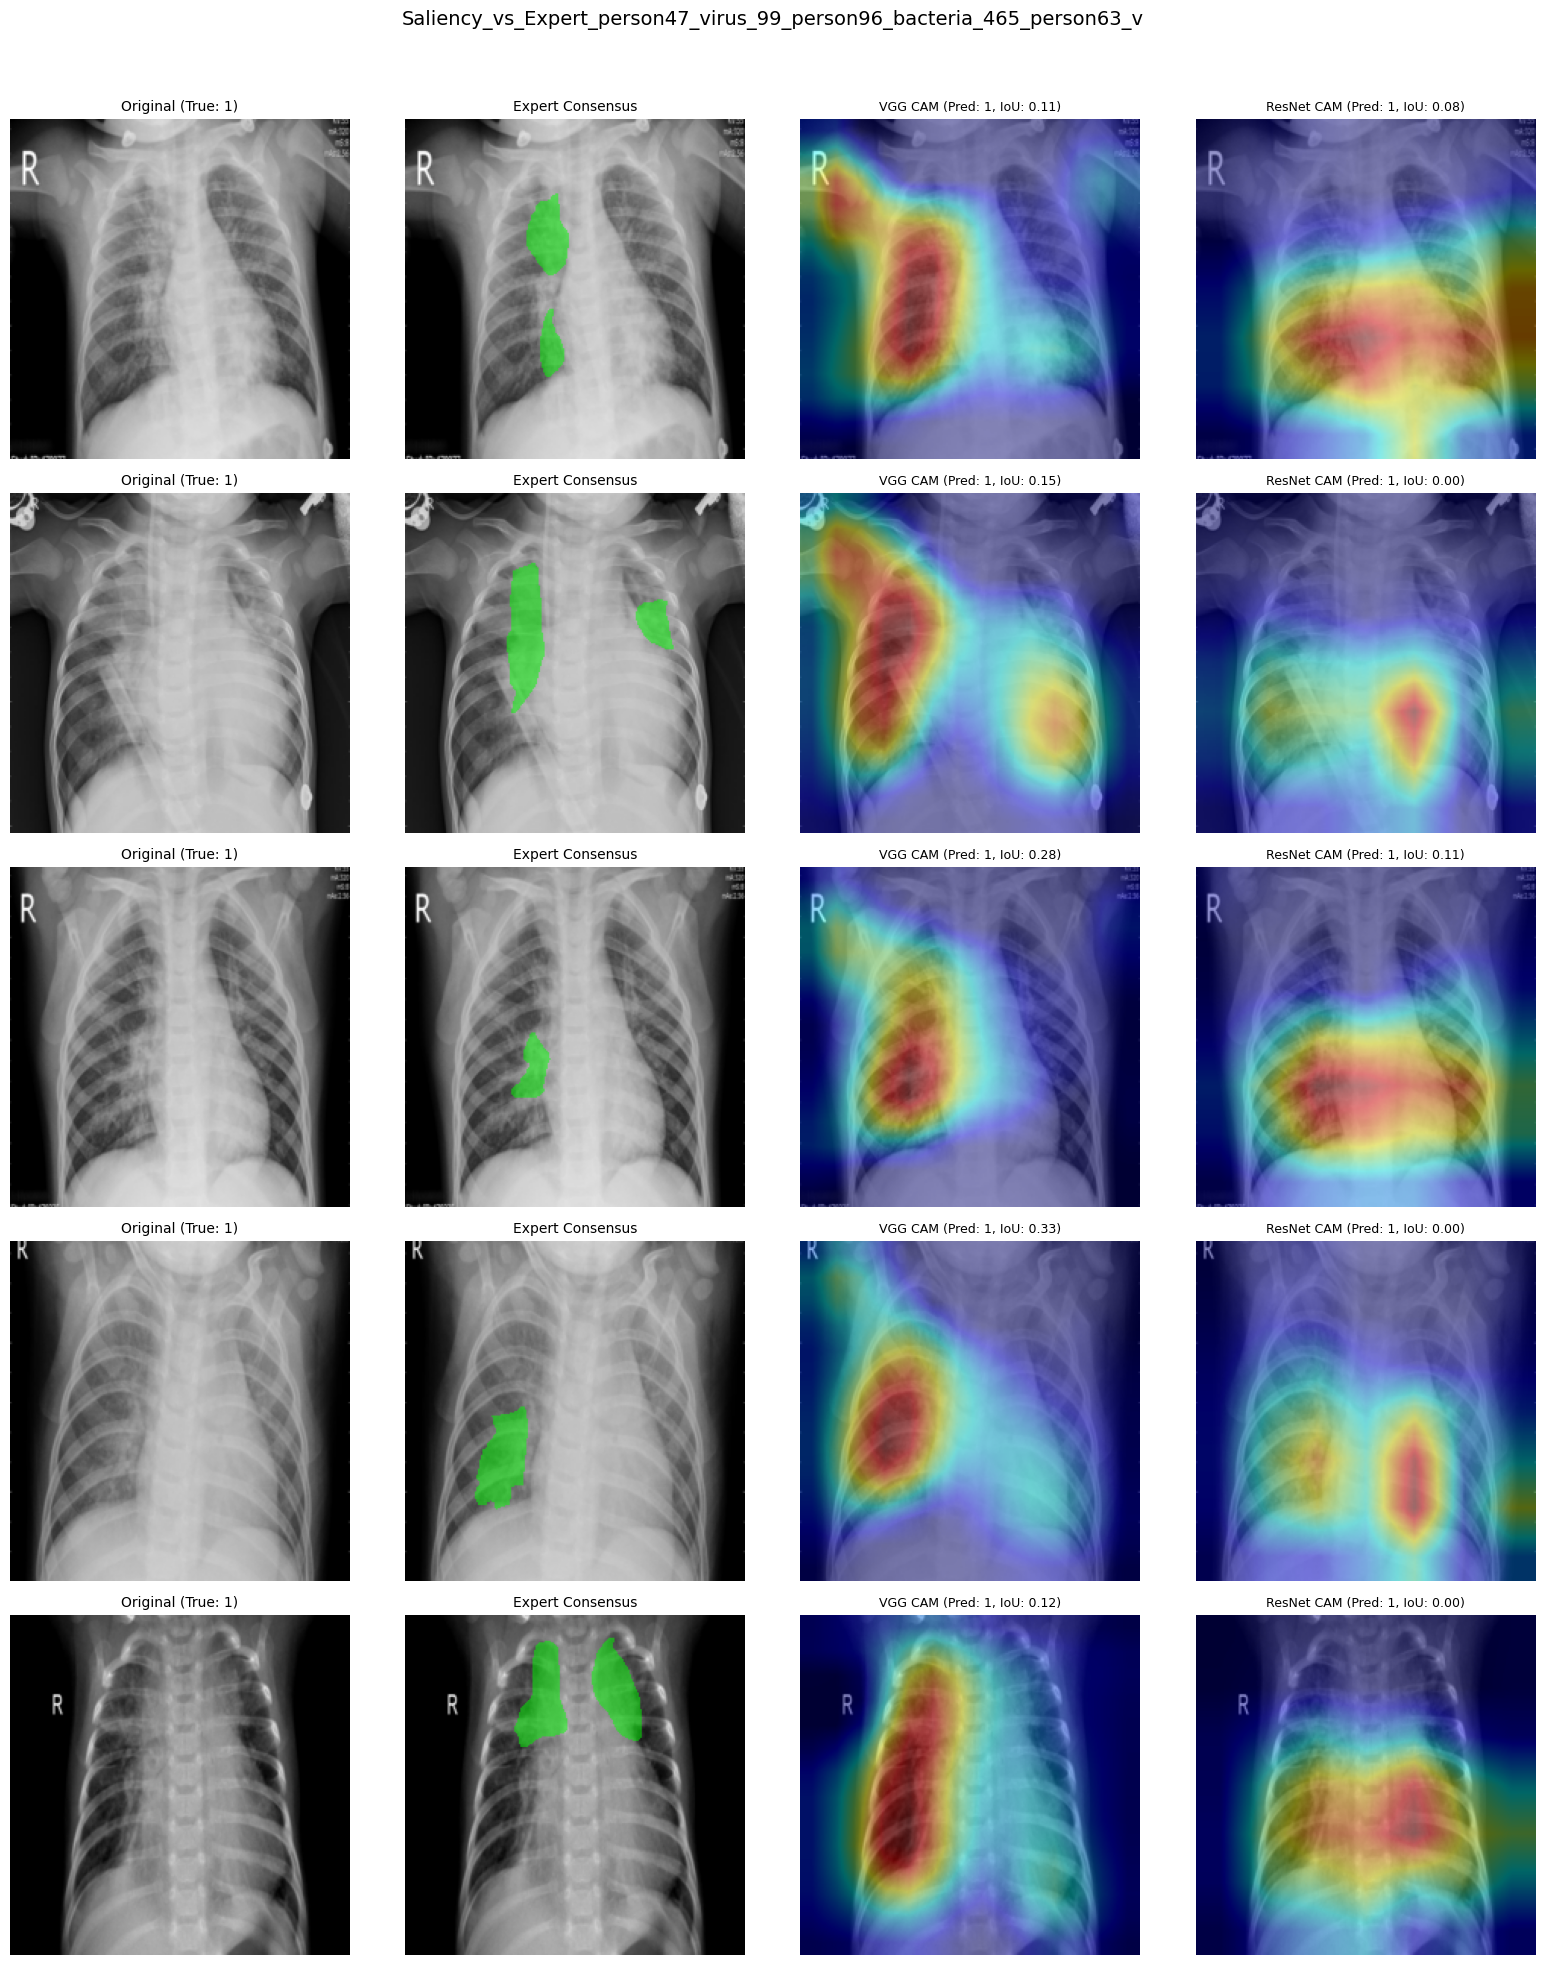

In [28]:
# Cell: Visualize Saliency (VGG & ResNet CAM) vs. Expert Consensus with IoU

# This cell assumes:
# - Modules (utils, models, saliency, datamodule, os, json, pd, torch, transforms) are imported.
# - Paths (PATH_TO_CKPT_RN, PATH_TO_CKPT_VGG, ANNOTATED_MASKS_DIR, etc.) are defined.
# - Annotation processing parameters (INITIAL_PRE_CLOSING_KERNEL_SIZE, etc.) are defined.
# - 'annotations_metadata' (filtered list of dicts), 'dm' (Datamodule instance, setup),
#   'device', 'MODEL_INPUT_SIZE' are available from previous cells.

import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import transforms # Ensure transforms is imported if not already globally
import os # For path operations like creating directory and joining paths

# --- Helper Function for Overlaying CAMs (defined locally in this cell) ---
def overlay_gradcam_on_image(img_tensor, cam_map, alpha=0.5):
    """
    Overlays a CAM/GradCAM heatmap on an image.
    Args:
        img_tensor (torch.Tensor): Image tensor of shape [1, C, H, W], range [0,1].
        cam_map (np.ndarray): 2D CAM/GradCAM map, range [0,1].
        alpha (float): Transparency for the heatmap.
    Returns:
        np.ndarray: Image with heatmap overlay, range [0,255], uint8.
    """
    img_np = img_tensor.squeeze(0).cpu().numpy()  # [C, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, C]
    img_np = (img_np * 255).astype(np.uint8)

    cam_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap_rgb, alpha, 0)
    return overlay

# --- Configuration for this Cell (ensure these are set in your notebook) ---
# These should be defined in your notebook setup cells
# N_IMAGES_TO_PLOT = 5 
# PROCESS_ALL_IMAGES_WITH_VALID_CONSENSUS = False # If True, will plot all valid images in one figure
# VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL = 0.74
# ALPHA_OVERLAY = 0.4
# PATH_TO_CKPT_RN = "checkpoints/rn_True_True_0.05.ckpt" 
# PATH_TO_CKPT_VGG = "checkpoints/vgg_True_True_0.03.ckpt" 
OUTPUT_PLOT_DIR = "plots" # Subfolder to save the plot

# --- Load Models ---
# Assuming rn_model_wrapper, vgg_model_wrapper, rn_model_eval, vgg_model_eval,
# and device are already loaded/defined from a previous cell.

# --- 1. Identify Images with Valid Consensus ---
temp_consensus_masks_dict_cell = {}
valid_consensus_image_info = [] 

print("Generating consensus masks to identify valid images for plotting...")
# Ensure annotations_metadata, ANNOTATED_MASKS_DIR, MODEL_INPUT_SIZE, 
# and consensus/annotation processing parameters are defined.
unique_annotated_images = sorted(list(set(record['image_name'] for record in annotations_metadata)))

for img_name in unique_annotated_images:
    raw_masks_tuples = utils.get_masks_for_image_from_metadata(
        img_name, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE
    )
    if not raw_masks_tuples: continue

    base_processed_masks = []
    for rm, an in raw_masks_tuples:
        processed_mask = utils.process_circled_annotation(
            rm, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, 
            OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, 
            FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER
        )
        base_processed_masks.append(processed_mask if processed_mask is not None else np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8))
    
    final_consensus = utils.create_consensus_mask(
        base_processed_masks, CONSENSUS_POST_FILTER_TYPE, 
        CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD
    )

    if final_consensus is not None and final_consensus.sum() > 0:
        temp_consensus_masks_dict_cell[img_name] = final_consensus
        try:
            original_idx = next(i for i, path in enumerate(dm.test_ds.imgs) if img_name in path)
            valid_consensus_image_info.append({'name': img_name, 'idx': original_idx})
        except StopIteration:
            pass 

if not valid_consensus_image_info:
    print("No images found with non-empty consensus masks that are also in the test dataset.")
else:
    print(f"Found {len(valid_consensus_image_info)} images with non-empty consensus for potential plotting.")

    # --- 2. Sample N Images (or all) ---
    if PROCESS_ALL_IMAGES_WITH_VALID_CONSENSUS:
        images_to_plot_info = valid_consensus_image_info
    else:
        num_to_sample = min(N_IMAGES_TO_PLOT, len(valid_consensus_image_info))
        images_to_plot_info = [valid_consensus_image_info[i] for i in np.random.choice(len(valid_consensus_image_info), num_to_sample, replace=False)] if num_to_sample > 0 else []
    
    N_actual_images_to_plot = len(images_to_plot_info)
    print(f"Selected {N_actual_images_to_plot} images for plotting.")

    if N_actual_images_to_plot > 0:
        # --- 3. Load Data, Generate CAMs and IoUs for Selected Images ---
        X_plot_list, y_plot_list, consensus_masks_for_plot = [], [], []
        image_filenames_for_plot_title = [] # To store filenames for the plot title/save name

        for info in images_to_plot_info:
            img_tensor, label_tensor = dm.test_ds[info['idx']]
            X_plot_list.append(img_tensor)
            y_plot_list.append(label_tensor)
            consensus_masks_for_plot.append(temp_consensus_masks_dict_cell[info['name']])
            image_filenames_for_plot_title.append(info['name'].split('.')[0]) # Get filename without extension
        
        X_plot = torch.stack(X_plot_list).to(device)
        y_plot = torch.tensor(y_plot_list, dtype=torch.float32).to(device)

        with torch.no_grad(): 
            pred_vgg_plot = vgg_model_wrapper.predict(X_plot)
            pred_rn_plot = rn_model_wrapper.predict(X_plot)

        cam_vgg_tool = saliency.CAM(vgg_model_eval)
        cam_rn_tool = saliency.CAM(rn_model_eval)
        
        cams_vgg_plot_list, cams_rn_plot_list = [], []
        ious_vgg_list, ious_rn_list = [], []

        print("Generating CAMs and calculating IoUs...")
        for i in range(N_actual_images_to_plot):
            input_img_tensor = X_plot[[i]]
            expert_consensus = consensus_masks_for_plot[i]

            cam_vgg_raw = cam_vgg_tool(input_img_tensor)
            cams_vgg_plot_list.append(cam_vgg_raw)
            bin_cam_vgg = utils.binarize_saliency_map(cam_vgg_raw, threshold_value=VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL)
            ious_vgg_list.append(utils.calculate_iou(bin_cam_vgg, expert_consensus) if bin_cam_vgg is not None else 0.0)

            cam_rn_raw = cam_rn_tool(input_img_tensor)
            cams_rn_plot_list.append(cam_rn_raw)
            bin_cam_rn = utils.binarize_saliency_map(cam_rn_raw, threshold_value=VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL)
            ious_rn_list.append(utils.calculate_iou(bin_cam_rn, expert_consensus) if bin_cam_rn is not None else 0.0)
        
        if hasattr(cam_vgg_tool, 'remove_hook'): cam_vgg_tool.remove_hook()
        if hasattr(cam_rn_tool, 'remove_hook'): cam_rn_tool.remove_hook()

        # --- 4. Plotting ---
        fig_plot, axes_plot = plt.subplots(N_actual_images_to_plot, 4, figsize=(16, N_actual_images_to_plot * 4))
        if N_actual_images_to_plot == 1: axes_plot = np.array([axes_plot])

        for i in range(N_actual_images_to_plot):
            original_pil_img_plot = transforms.ToPILImage()(X_plot[i].cpu())

            axes_plot[i, 0].imshow(original_pil_img_plot)
            axes_plot[i, 0].set_title(f"Original (True: {y_plot[i].item():.0f})", fontsize=10)
            axes_plot[i, 0].axis('off')

            overlay_consensus = utils.overlay_binary_mask(original_pil_img_plot.copy(), consensus_masks_for_plot[i], mask_color=(0, 255, 0), alpha=0.5)
            axes_plot[i, 1].imshow(overlay_consensus)
            axes_plot[i, 1].set_title("Expert Consensus", fontsize=10)
            axes_plot[i, 1].axis('off')

            overlay_vgg = overlay_gradcam_on_image(X_plot[i:i+1].cpu(), cams_vgg_plot_list[i], alpha=ALPHA_OVERLAY)
            axes_plot[i, 2].imshow(overlay_vgg)
            axes_plot[i, 2].set_title(f"VGG CAM (Pred: {pred_vgg_plot[i].item():.0f}, IoU: {ious_vgg_list[i]:.2f})", fontsize=9)
            axes_plot[i, 2].axis('off')

            overlay_rn = overlay_gradcam_on_image(X_plot[i:i+1].cpu(), cams_rn_plot_list[i], alpha=ALPHA_OVERLAY)
            axes_plot[i, 3].imshow(overlay_rn)
            axes_plot[i, 3].set_title(f"ResNet CAM (Pred: {pred_rn_plot[i].item():.0f}, IoU: {ious_rn_list[i]:.2f})", fontsize=9)
            axes_plot[i, 3].axis('off')
        
        plot_title = f"Saliency_vs_Expert_Consensus_Thresh{VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL}"
        if not PROCESS_ALL_IMAGES_WITH_VALID_CONSENSUS and N_actual_images_to_plot > 0:
            # Add first few image names to title if plotting a sample
            title_image_names = "_".join(image_filenames_for_plot_title[:min(3, N_actual_images_to_plot)])
            plot_title = f"Saliency_vs_Expert_{title_image_names[:50]}" # Truncate if too long

        plt.suptitle(plot_title, fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        # --- Save the plot ---
        os.makedirs(OUTPUT_PLOT_DIR, exist_ok=True) # Ensure the 'plots' directory exists
        save_filename = f"{plot_title.replace(' ', '_').replace(':', '').replace('/', '_')}.png"
        save_path = os.path.join(OUTPUT_PLOT_DIR, save_filename)
        try:
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            print(f"Plot saved to: {save_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        
        plt.show()


Using existing list of 24 valid consensus images.
Selected random image for 2x2 plot: person173_bacteria_830.jpeg


/var/folders/jt/lhtzzpdd2vs1b862wm2r6ynm0000gn/T/ipykernel_15987/1839271060.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_single_2x2 = torch.tensor(y_single_2x2, dtype=torch.float32).to(device)


2x2 comparison plot saved to: plots/comparison_plot_person173_bacteria_830.png


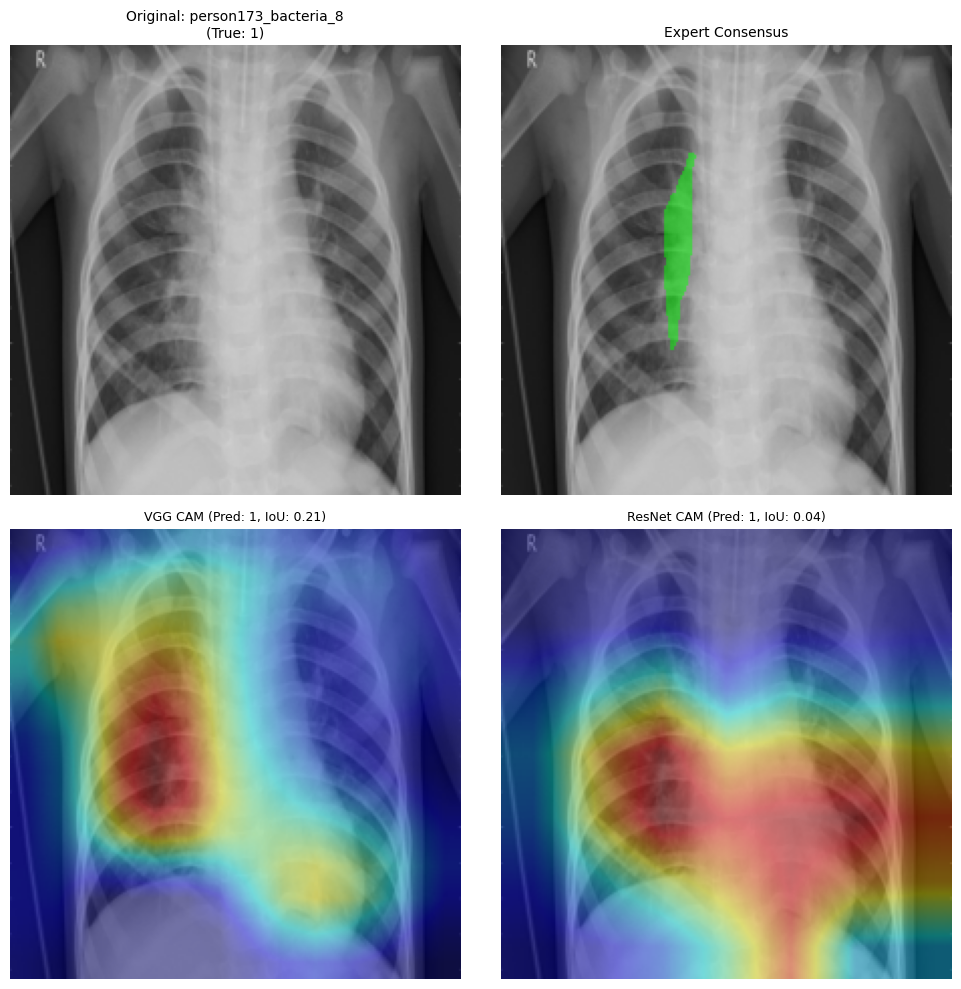

In [31]:
# Cell: Generate and Save a Random 2x2 Saliency Comparison Plot

# This cell assumes:
# - Modules (utils, models, saliency, datamodule, os, torch, transforms, Image, plt, np, cv2) are imported.
# - Paths (PATH_TO_CKPT_RN, PATH_TO_CKPT_VGG, ANNOTATED_MASKS_DIR, etc.) are defined.
# - Annotation processing parameters (INITIAL_PRE_CLOSING_KERNEL_SIZE, etc.) are defined.
# - 'annotations_metadata' (filtered list), 'dm' (Datamodule instance, setup),
#   'device', 'MODEL_INPUT_SIZE', 'rn_model_eval', 'vgg_model_eval' are available.
# - The helper function 'overlay_gradcam_on_image' is defined (e.g., locally or in utils).
# - VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL and ALPHA_OVERLAY are defined.

# --- Configuration for this Cell ---
OUTPUT_PLOT_DIR_2x2 = "plots" # Subfolder to save the plot

# --- Ensure helper function is available (if not in utils) ---
if 'overlay_gradcam_on_image' not in globals():
    def overlay_gradcam_on_image(img_tensor, cam_map, alpha=0.5):
        img_np = img_tensor.squeeze(0).cpu().numpy() 
        img_np = np.transpose(img_np, (1, 2, 0))    
        img_np = (img_np * 255).astype(np.uint8)
        cam_resized = cv2.resize(cam_map, (img_np.shape[1], img_np.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap_rgb, alpha, 0)
        return overlay
    print("Defined overlay_gradcam_on_image locally for 2x2 plot cell.")


# --- 1. Identify Images with Valid Consensus (Simplified from previous cell) ---
# We need temp_consensus_masks_dict_cell and valid_consensus_image_info
# If they don't exist from a previous run of a cell like the one above, recalculate.
if 'valid_consensus_image_info' not in locals() or not valid_consensus_image_info:
    print("Recalculating valid consensus images for 2x2 plot...")
    temp_consensus_masks_dict_cell_2x2 = {}
    valid_consensus_image_info_2x2 = []
    unique_annotated_images_2x2 = sorted(list(set(record['image_name'] for record in annotations_metadata)))
    for img_name_2x2 in unique_annotated_images_2x2:
        raw_masks_tuples_2x2 = utils.get_masks_for_image_from_metadata(img_name_2x2, annotations_metadata, ANNOTATED_MASKS_DIR, target_size=MODEL_INPUT_SIZE)
        if not raw_masks_tuples_2x2: continue
        base_processed_masks_2x2 = [utils.process_circled_annotation(rm, INITIAL_PRE_CLOSING_KERNEL_SIZE, SOLIDITY_THRESHOLD, OUTLINE_FILL_CLOSING_KERNEL_SIZE, OUTLINE_EROSION_KERNEL_SIZE, FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE, MIN_CONTOUR_AREA_FILTER) or np.zeros(MODEL_INPUT_SIZE, dtype=np.uint8) for rm, an in raw_masks_tuples_2x2]
        final_consensus_2x2 = utils.create_consensus_mask(base_processed_masks_2x2, CONSENSUS_POST_FILTER_TYPE, CONSENSUS_POST_FILTER_KERNEL_SIZE, CONSENSUS_METHOD)
        if final_consensus_2x2 is not None and final_consensus_2x2.sum() > 0:
            temp_consensus_masks_dict_cell_2x2[img_name_2x2] = final_consensus_2x2
            try:
                original_idx_2x2 = next(i for i, path in enumerate(dm.test_ds.imgs) if img_name_2x2 in path)
                valid_consensus_image_info_2x2.append({'name': img_name_2x2, 'idx': original_idx_2x2})
            except StopIteration: pass
    if not valid_consensus_image_info_2x2:
        print("No images with valid consensus found. Cannot generate 2x2 plot.")
        # Fallback or exit if you prefer
    else:
        print(f"Found {len(valid_consensus_image_info_2x2)} images for random 2x2 plot selection.")
else: # Use existing valid_consensus_image_info if available
    valid_consensus_image_info_2x2 = valid_consensus_image_info
    temp_consensus_masks_dict_cell_2x2 = temp_consensus_masks_dict_cell
    print(f"Using existing list of {len(valid_consensus_image_info_2x2)} valid consensus images.")


if valid_consensus_image_info_2x2:
    # --- 2. Select ONE Random Image ---
    selected_info_2x2 = np.random.choice(valid_consensus_image_info_2x2) # np.random.choice returns an element directly
    image_name_2x2 = selected_info_2x2['name']
    image_idx_2x2 = selected_info_2x2['idx']
    print(f"Selected random image for 2x2 plot: {image_name_2x2}")

    # --- 3. Load Data for the Selected Image ---
    X_single_2x2, y_single_2x2 = dm.test_ds[image_idx_2x2]
    X_single_2x2 = X_single_2x2.unsqueeze(0).to(device) # Add batch dim and move to device
    y_single_2x2 = torch.tensor(y_single_2x2, dtype=torch.float32).to(device)
    
    original_pil_img_2x2 = transforms.ToPILImage()(X_single_2x2.squeeze(0).cpu())
    expert_consensus_2x2 = temp_consensus_masks_dict_cell_2x2[image_name_2x2]

    # --- 4. Generate CAMs for VGG and ResNet ---
    # Ensure models are loaded (rn_model_eval, vgg_model_eval)
    if 'vgg_model_eval' not in locals() or 'rn_model_eval' not in locals():
        print("Error: VGG or ResNet model not loaded. Please run model loading cell.")
    else:
        cam_vgg_tool_2x2 = saliency.CAM(vgg_model_eval)
        cam_rn_tool_2x2 = saliency.CAM(rn_model_eval)

        cam_vgg_raw_2x2 = cam_vgg_tool_2x2(X_single_2x2)
        cam_rn_raw_2x2 = cam_rn_tool_2x2(X_single_2x2)

        if hasattr(cam_vgg_tool_2x2, 'remove_hook'): cam_vgg_tool_2x2.remove_hook()
        if hasattr(cam_rn_tool_2x2, 'remove_hook'): cam_rn_tool_2x2.remove_hook()

        # --- 5. Create 2x2 Plot ---
        fig_2x2, axes_2x2 = plt.subplots(2, 2, figsize=(10, 10)) # Square figure

        # Top-left: Original Image
        axes_2x2[0, 0].imshow(original_pil_img_2x2)
        axes_2x2[0, 0].set_title(f"Original: {image_name_2x2.split('.')[0][:20]}\n(True: {y_single_2x2.item():.0f})", fontsize=10)
        axes_2x2[0, 0].axis('off')

        # Top-right: Expert Consensus Overlay
        overlay_consensus_2x2 = utils.overlay_binary_mask(original_pil_img_2x2.copy(), expert_consensus_2x2, mask_color=(0, 255, 0), alpha=0.5)
        axes_2x2[0, 1].imshow(overlay_consensus_2x2)
        axes_2x2[0, 1].set_title("Expert Consensus", fontsize=10)
        axes_2x2[0, 1].axis('off')

        # Bottom-left: VGG CAM Overlay
        # Ensure ALPHA_OVERLAY and VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL are defined
        current_alpha_overlay = ALPHA_OVERLAY if 'ALPHA_OVERLAY' in locals() else 0.4
        current_vis_bin_thresh = VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL if 'VIS_SALIENCY_BINARIZATION_THRESHOLD_CELL' in locals() else 0.74
        
        bin_cam_vgg_2x2 = utils.binarize_saliency_map(cam_vgg_raw_2x2, threshold_value=current_vis_bin_thresh)
        iou_vgg_2x2 = utils.calculate_iou(bin_cam_vgg_2x2, expert_consensus_2x2) if bin_cam_vgg_2x2 is not None else 0.0
        pred_vgg_2x2 = vgg_model_wrapper.predict(X_single_2x2).item()

        overlay_vgg_2x2 = overlay_gradcam_on_image(X_single_2x2.cpu(), cam_vgg_raw_2x2, alpha=current_alpha_overlay)
        axes_2x2[1, 0].imshow(overlay_vgg_2x2)
        axes_2x2[1, 0].set_title(f"VGG CAM (Pred: {pred_vgg_2x2:.0f}, IoU: {iou_vgg_2x2:.2f})", fontsize=9)
        axes_2x2[1, 0].axis('off')

        # Bottom-right: ResNet CAM Overlay
        bin_cam_rn_2x2 = utils.binarize_saliency_map(cam_rn_raw_2x2, threshold_value=current_vis_bin_thresh)
        iou_rn_2x2 = utils.calculate_iou(bin_cam_rn_2x2, expert_consensus_2x2) if bin_cam_rn_2x2 is not None else 0.0
        pred_rn_2x2 = rn_model_wrapper.predict(X_single_2x2).item()
        
        overlay_rn_2x2 = overlay_gradcam_on_image(X_single_2x2.cpu(), cam_rn_raw_2x2, alpha=current_alpha_overlay)
        axes_2x2[1, 1].imshow(overlay_rn_2x2)
        axes_2x2[1, 1].set_title(f"ResNet CAM (Pred: {pred_rn_2x2:.0f}, IoU: {iou_rn_2x2:.2f})", fontsize=9)
        axes_2x2[1, 1].axis('off')
        
        plt.tight_layout()
        
        # --- Save the 2x2 plot ---
        os.makedirs(OUTPUT_PLOT_DIR_2x2, exist_ok=True)
        img_filename_base = image_name_2x2.split('.')[0] # Remove extension
        save_filename_2x2 = f"comparison_plot_{img_filename_base}.png"
        save_path_2x2 = os.path.join(OUTPUT_PLOT_DIR_2x2, save_filename_2x2)
        try:
            plt.savefig(save_path_2x2, bbox_inches='tight', dpi=150)
            print(f"2x2 comparison plot saved to: {save_path_2x2}")
        except Exception as e:
            print(f"Error saving 2x2 plot: {e}")
            
        plt.show()
else:
    print("Not enough data to generate a 2x2 plot.")



# Parse the content of the .json in /evaluation/ and write to a .csv

In [55]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics_name = set(k.replace("test/", "").split("_")[0]for k in results.keys())

    for name in metrics_name:
        metrics[name] = {
            "mean": results[f'test/{name}_mean'],
            "pm": (results[f'test/{name}_ci_upper'] - results[f'test/{name}_ci_lower'])/2
        }
    return metrics

payload = "model,linear,pretrained"


for i, evals in enumerate(sorted(os.listdir("evaluation"))):
    
    # Opne json
    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)

    # Format csv row
    model, linear, pretrained = evals.split("_")[:3]
    metrics = parse_json_and_format_for_latex(res)

    # Add header 
    if i == 0:
        for name in metrics.keys():
            payload += f",{name},pm"
        payload += "\n"

    # Add values
    payload += f"{model},{linear},{pretrained}"
    for name in metrics.keys():
        mean = metrics[name]["mean"] * 100
        pm = metrics[name]["pm"] * 100
        payload += f",{mean},{pm}"
    payload+="\n"

# Dump to csv
with open("plots/results.csv", "w") as f:
    f.write(payload)

# Read .csv with results and create latex table

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('plots/results.csv')

# Process the data to restructure it
# Map "linear" column to "Adapted Classifier" for the table
df['adapted_classifier'] = df['linear'].map({True: 'Yes', False: 'No'})
df['pretrained_text'] = df['pretrained'].map({True: 'Yes', False: 'No'})

# Format metrics with their plus/minus values
metrics = ['accuracy', 'f1', 'auroc', 'specificity']  # Changed to use accuracy and f1 instead of precision and recall
for i, row in df.iterrows():
    for metric in metrics:
        # Assuming the pm column follows each metric column
        metric_idx = df.columns.get_loc(metric)
        pm_idx = metric_idx + 1
        
        # Format the value with its plus/minus
        if pd.notna(row[metric]) and pd.notna(row[df.columns[pm_idx]]):
            df.at[i, f"{metric}_formatted"] = f"{row[metric]:.2f} $\\pm$ {row[df.columns[pm_idx]]:.2f}"
        else:
            df.at[i, f"{metric}_formatted"] = "- $\\pm$ -"

# Generate LaTeX table
latex_table = """\\begin{table*}[t]
    \\centering
    \\setlength{\\tabcolsep}{3pt}
    \\caption{Model Performance Metrics}
    \\begin{tabularx}{\\textwidth}{lYYYcccc}
        \\toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC & Specifity\\\\
        \\midrule
"""

# Group by model to handle the multirow structure
models = df['model'].unique()
mapped_names = {
    "vgg": "VGG-16",
    "in": "InceptionNet-V1",
    "an": "AlexNet",
    "rn": "ResNet-50",
}
for i, model in enumerate(models):
    model_df = df[df['model'] == model]
    
    # Group by pretrained status
    pretrained_values = model_df['pretrained'].unique()
    
    # Count rows for multirow
    model_rows = len(model_df)
    model_name = mapped_names[model]
    for j, pretrained in enumerate(pretrained_values):
        pretrained_df = model_df[model_df['pretrained'] == pretrained]
        pretrained_rows = len(pretrained_df)
        
        # Add pretrained status with multirow
        for k, (idx, row) in enumerate(pretrained_df.iterrows()):
            if k == 0 and j == 0:
                # First row of the model
                latex_table += f"        \\multirow{{{model_rows}}}{{*}}{{{model_name}}} &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            elif k == 0:
                # First row of a new pretrained group
                latex_table += f"         &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            else:
                # Continuation rows
                latex_table += "         &                          "

            latex_table += f" &   {row['adapted_classifier'] if model not in {'in', 'rn'} else '-'}  &   {row['accuracy_formatted']}     &   {row['f1_formatted']}    &   {row['auroc_formatted']} &   {row['specificity_formatted']}\\\\\n"
        
        # Add cmidrule between pretrained groups within the same model (except after the last pretrained group)
        if j < len(pretrained_values) - 1:
            latex_table += "        \\cmidrule(lr){2-6}\n"
    
    # Add midrule between models (except after the last model)
    if i < len(models) - 1:
        latex_table += "        \\midrule\n"

# Close the table
latex_table += """        \\bottomrule
    \\end{tabularx}
    \\label{tab:Performance}
\\end{table*}
"""

print(latex_table)
# Optionally save to a file
with open('plots/results.tex', 'w') as f:
    f.write(latex_table)

\begin{table*}[t]
    \centering
    \setlength{\tabcolsep}{3pt}
    \caption{Model Performance Metrics}
    \begin{tabularx}{\textwidth}{lYYYccc}
        \toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC & Specifity\\
        \midrule
        \multirow{4}{*}{AlexNet} &  \multirow{2}{*}{No} &   No  &   87.42 $\pm$ 2.56     &   90.29 $\pm$ 2.11    &   94.50 $\pm$ 1.72 &   76.84 $\pm$ 5.34\\
         &                           &   Yes  &   87.48 $\pm$ 2.48     &   90.22 $\pm$ 2.05    &   93.40 $\pm$ 1.88 &   78.98 $\pm$ 5.11\\
        \cmidrule(lr){2-6}
         &  \multirow{2}{*}{Yes} &   No  &   91.98 $\pm$ 2.16     &   93.75 $\pm$ 1.72    &   97.01 $\pm$ 1.08 &   84.60 $\pm$ 4.55\\
         &                           &   Yes  &   90.34 $\pm$ 2.24     &   92.72 $\pm$ 1.79    &   96.72 $\pm$ 1.13 &   76.40 $\pm$ 5.06\\
        \midrule
        \multirow{2}{*}{InceptionNet-V1} &  \multirow{1}{*}{No} &   -  &   87.92 $\pm$ 2.49     &   91.11 $\pm$ 1.94  

# Get nice plots from the metrics in /evaluation/

In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Specify the CSV file path
CSV_FILE = "plots/results.csv"  

# Read and process the CSV file with the new format
def read_csv_and_process(csv_file_path):
    """
    Read the CSV file with structure:
    model,linear,pretrained,accuracy,pm,precision,pm,specificity,pm,recall,pm,f1,pm,auroc,pm
    """
    # Read the raw CSV
    df = pd.read_csv(csv_file_path)
    
    # Create a clean dataframe with proper structure
    processed_data = []
    
    # Calculate the number of metrics (excluding the first 3 columns and accounting for the pm columns)
    num_columns = len(df.columns)
    num_metrics = (num_columns - 3) // 2  # Each metric has a value and a pm column
    
    # Process each row
    for _, row in df.iterrows():
        model = row[0]  # model
        linear = row[1]  # linear
        pretrained = row[2]  # pretrained
        model_name = f"{model}_{linear}_{pretrained}"
        if not linear or not pretrained:
            continue
        
        # Extract metric values and their confidence intervals
        metrics_data = {}
        metrics_index = 3  # Start from the 4th column (0-indexed)
        
        # Expected metrics in order: accuracy, precision, specificity, recall, f1, auroc
        metric_names = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
        
        for i in range(num_metrics):
            if metrics_index < len(row):
                metric_name = metric_names[i] if i < len(metric_names) else f"metric_{i}"
                metrics_data[f"{metric_name}_mean"] = row[metrics_index]
                metrics_data[f"{metric_name}_ci_half"] = row[metrics_index + 1]  # pm value
                metrics_index += 2  # Move to the next metric
        
        # Create a row for the model
        processed_row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': model_name,
            **metrics_data  # Add all metrics data
        }
        
        processed_data.append(processed_row)
    
    return pd.DataFrame(processed_data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create a directory for plots if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    for metric in metrics:
        # Skip metrics that don't exist in the dataframe
        if f"{metric}_mean" not in df.columns:
            print(f"Skipping {metric} as it's not in the data")
            continue
            
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Generated plots for available metrics")

# Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Get all metric columns
    metric_columns = [col for col in df.columns if col.endswith('_mean')]
    ci_columns = [col for col in df.columns if col.endswith('_ci_half')]
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metric_columns,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_columns,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")


# Create plots directory
os.makedirs("plots", exist_ok=True)

try:
    # Process the CSV file
    df = read_csv_and_process(CSV_FILE)

    # Create individual plots for each metric
    plot_metrics(df)
    
    # Create a combined plot with all metrics
    plot_all_metrics_together(df)
    
except FileNotFoundError:
    raise Exception(f"CSV file '{CSV_FILE}' not found. Please make sure the file exists.")

/tmp/ipykernel_419481/2756304362.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[0]  # model
/tmp/ipykernel_419481/2756304362.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  linear = row[1]  # linear
/tmp/ipykernel_419481/2756304362.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pretrained = row[2]  # pretrained
/tmp/ipykernel_419481/2756304362.py:45: FutureWarning: Series.__getitem__ treating keys as pos

Generated plots for available metrics
Generated combined metrics plot


# Exploring Annotations

### 1. Imports and Setup

In [ ]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import importlib
from torchvision import transforms
import cv2

import utils

BASE_ANNOTATIONS_DIR = "data/annotations"
METADATA_PATH = os.path.join(BASE_ANNOTATIONS_DIR, "metadata.json")
ANNOTATED_MASKS_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "annotated")
ORIGINAL_IMAGES_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "original")

TARGET_MASK_SIZE = (224, 224)

CIRCLE_CLOSING_KERNEL_SIZE = 7 
CIRCLE_EROSION_KERNEL_SIZE = 7 
MIN_CONTOUR_AREA_FILTER = 20   

INITIAL_PRE_CLOSING_KERNEL_SIZE = 3  # For initial small gap closing (0 to disable)
SOLIDITY_THRESHOLD = 0.6             # Solidity < threshold means it's an OUTLINE. Range (0.0 to 1.0)
                                     # Lower for thinner/more broken outlines, Higher if outlines are quite solid.
OUTLINE_FILL_CLOSING_KERNEL_SIZE = 7 # To close gaps in detected outlines before filling (0 to disable)
OUTLINE_EROSION_KERNEL_SIZE = 7      # To "remove" line thickness from filled OUTLINES (0 to disable)
FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE = 5 # To close internal holes in detected FILLED regions (0 to disable)
MIN_CONTOUR_AREA_FILTER = 20         # Minimum pixel area to consider a contour significant

CONSENSUS_POST_FILTER_TYPE = 'open' # Filter applied to individual processed masks before consensus
CONSENSUS_POST_FILTER_KERNEL_SIZE = 3
CONSENSUS_METHOD = 'intersection'


### 2. Basics Statistics from Metadata

In [ ]:
print("\n--- Basic Statistics ---")

num_unique_images = df_metadata['image_name'].nunique()
#print(f"Number of unique images with annotations: {num_unique_images}")

print("\nAnnotations per annotator:")
print(df_metadata['annotator_name'].value_counts())


### 3. Visualizing annotations

### 4. IoU Examples

### Explore thresholds